In [1]:
#Import necessary packages
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import os
from matplotlib.patches import Polygon
import numpy as np
import matplotlib as mpl

# Supply Chain Input Data

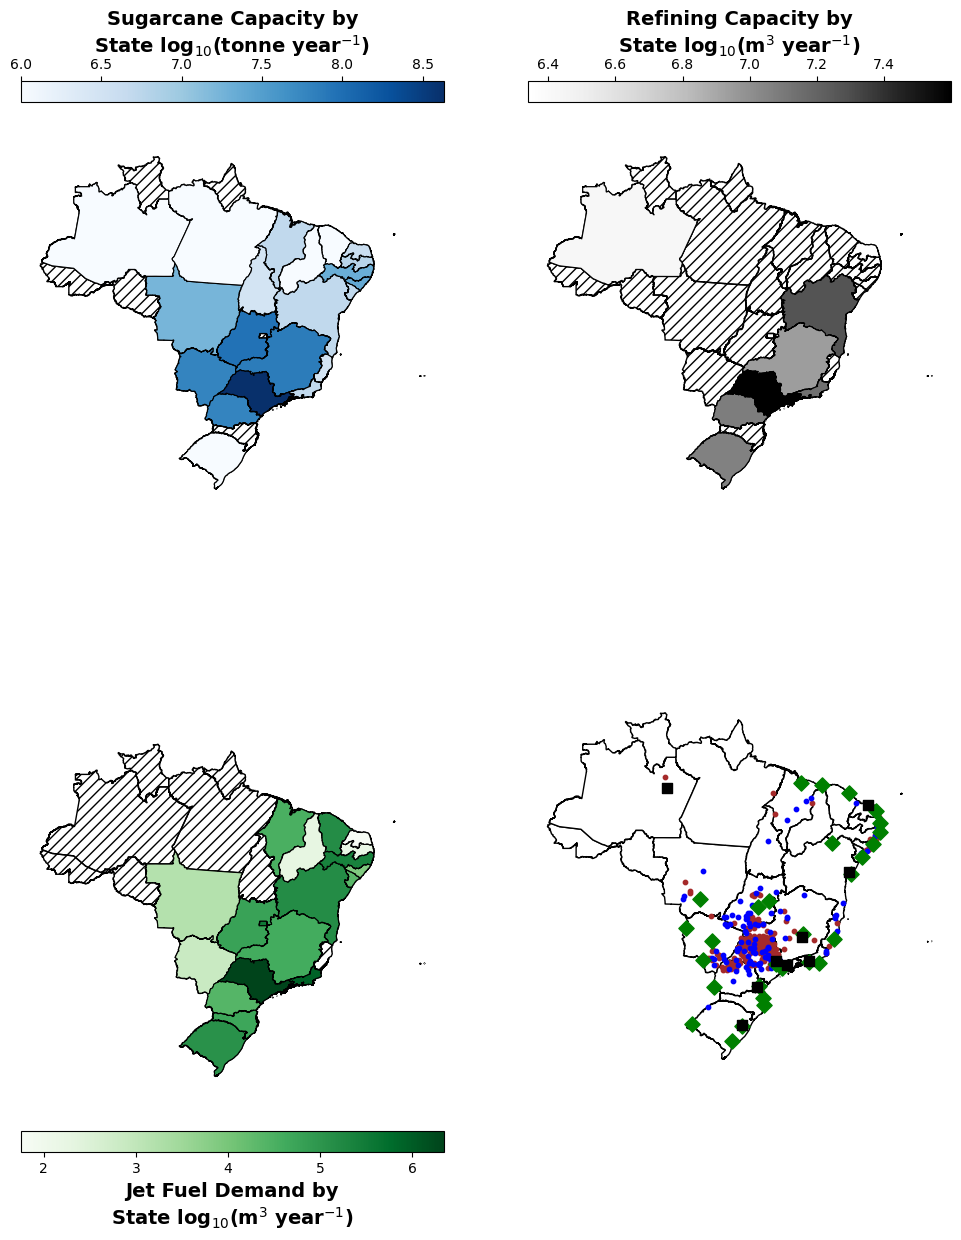

In [2]:
#Plot sugarcane capacity, refining capacity, jet fuel demand, and infrastructure locations by Brazilian state.
#This cell takes ~2 min to run

#Load the required input data
brazil_states = gpd.read_file("gadm41_BRA_1.shp")
mill_data = pd.read_excel('335MillsLatitudesLongitudes.xlsx')
ref_data = pd.read_excel('OilRefineriesLatLong.xlsx')
airport_data = pd.read_excel('AirportsLatitudeLongitude.xlsx')
eth_mill_data = pd.read_excel('335MillsLatitudesLongitudes.xlsx', sheet_name= 'ethanol')
annexed_mill_data = pd.read_excel('335MillsLatitudesLongitudes.xlsx', sheet_name= 'annexed')

#Sum and assign Capacity and Demand by state
#Mills
#Find the state its located in
for i in range(len(mill_data['Mills'])):
# Define your lat/lon point
    point = Point(mill_data['Longitude'][i], mill_data['Latitude'][i])  # Note: (lon, lat) for Shapely
    # Find the state containing the point
    containing_state = brazil_states[brazil_states.contains(point)]

    if not containing_state.empty:
        state_name = containing_state.iloc[0]['NAME_1']
        mill_data.loc[i,'State'] = state_name
    else:
        print("The point is not inside any Brazilian state.")

#Sum the capcity by state
state_capacity = {}
for i in range(len(brazil_states['NAME_1'])):
    c = 0
    for j in range(len(mill_data['Sugarcane Capacity (ton)'])):
        if mill_data['State'][j] == brazil_states['NAME_1'][i]:
            c = c + mill_data['Sugarcane Capacity (ton)'][j]
    state_capacity[brazil_states['NAME_1'][i]] = c

#Assign capacity to the state geopandas dataframe
for i in range(len(brazil_states['NAME_1'])):
    if state_capacity[brazil_states['NAME_1'][i]] > 1:
        brazil_states.loc[i,'Capacity']= np.log10(state_capacity[brazil_states['NAME_1'][i]])

#Refineries
for i in range(len(ref_data['refinery'])):
# Define your lat/lon point
    point = Point(ref_data['Longitude'][i], ref_data['Latitude'][i])  # Note: (lon, lat) for Shapely
    # Find the state containing the point
    containing_state = brazil_states[brazil_states.contains(point)]

    if not containing_state.empty:
        state_name = containing_state.iloc[0]['NAME_1']
        ref_data.loc[i,'State'] = state_name
    else:
        print("The point is not inside any Brazilian state.")

ref_state_capacity = {}
#Sum up capacity data by state
for i in range(len(brazil_states['NAME_1'])):
    c = 0
    for j in range(len(ref_data['Capacity m3 year'])):
        if ref_data['State'][j] == brazil_states['NAME_1'][i]:
            c = c + ref_data['Capacity m3 year'][j]
    ref_state_capacity[brazil_states['NAME_1'][i]] = c

#Assign capacity to the state geopandas dataframe
for i in range(len(brazil_states['NAME_1'])):
    if ref_state_capacity[brazil_states['NAME_1'][i]] > 1:
        brazil_states.loc[i,'Ref Capacity']= np.log10(ref_state_capacity[brazil_states['NAME_1'][i]])

#Airports
state_demand = {}
#Sum up demand data by state
for i in range(len(brazil_states['NAME_1'])):
    d = 0
    for j in range(len(airport_data['DEMANDA (M^3)'])):
        if airport_data['State'][j] == brazil_states['NAME_1'][i]:
            d = d + airport_data['DEMANDA (M^3)'][j]
    state_demand[brazil_states['NAME_1'][i]] = d

#Assign demand to the state geopandas dataframe
for i in range(len(brazil_states['NAME_1'])):
    if state_demand[brazil_states['NAME_1'][i]] > 1:
        brazil_states.loc[i,'demand']= np.log10(state_demand[brazil_states['NAME_1'][i]])

fig, ax = plt.subplots(2,2,figsize=(12, 14))
fig.subplots_adjust(hspace=0)
# fig.subplots_adjust(wspace=0)

#Plot Mill Capacities
# Choose a colormap
cmap = plt.cm.Blues
# Normalize the data to 0–1
norm = mpl.colors.Normalize(vmin=brazil_states['Capacity'].min(), vmax=brazil_states['Capacity'].max())

hatch_pattern = '///'  # You can use \\, --, .., etc.

# Plot with hatching
for _, row in brazil_states.iterrows():
    geom = row.geometry

    # Support both Polygon and MultiPolygon
    if geom.geom_type == 'Polygon':
        polys = [geom]
    elif geom.geom_type == 'MultiPolygon':
        polys = geom.geoms
    else:
        continue

    for poly in polys:
        patch = Polygon(
            list(poly.exterior.coords),
            facecolor='none',
            edgecolor='black',
            hatch=hatch_pattern
        )
        ax[0,0].add_patch(patch)

brazil_states.plot(column='Capacity', cmap=cmap, linewidth=0.8, ax=ax[0,0], edgecolor='black')

# Create colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # Only needed for older matplotlib versions
cbar = fig.colorbar(sm, ax=ax[0,0], orientation='horizontal', fraction=0.046, pad=0.07, location = 'top')
cbar.set_label('Sugarcane Capacity by\nState log$_{10}$(tonne year$^{-1}$)', fontweight='bold', fontsize = 14)

#Plot Refinery Capacity
# Choose a colormap
cmap = plt.cm.Greys
# Normalize the data to 0–1
norm = mpl.colors.Normalize(vmin=brazil_states['Ref Capacity'].min(), vmax=brazil_states['Ref Capacity'].max())

# Plot with hatching
for _, row in brazil_states.iterrows():
    geom = row.geometry

    # Support both Polygon and MultiPolygon
    if geom.geom_type == 'Polygon':
        polys = [geom]
    elif geom.geom_type == 'MultiPolygon':
        polys = geom.geoms
    else:
        continue

    for poly in polys:
        patch = Polygon(
            list(poly.exterior.coords),
            facecolor='none',
            edgecolor='black',
            hatch=hatch_pattern
        )
        ax[0,1].add_patch(patch)

brazil_states.plot(column='Ref Capacity', cmap=cmap, linewidth=0.8, ax=ax[0,1], edgecolor='black')

# Create colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # Only needed for older matplotlib versions
cbar = fig.colorbar(sm, ax=ax[0,1], orientation='horizontal', fraction=0.046, pad=0.07, location = 'top')
cbar.set_label('Refining Capacity by\nState log$_{10}$(m$^3$ year$^{-1}$)', fontweight='bold', fontsize = 14)

#Plot Airport Demand
# Choose a colormap
cmap = plt.cm.Greens
# Normalize the data to 0–1
norm = mpl.colors.Normalize(vmin=brazil_states['demand'].min(), vmax=brazil_states['demand'].max())

hatch_pattern = '///'  # You can use \\, --, .., etc.

# Plot with hatching
for _, row in brazil_states.iterrows():
    geom = row.geometry

    # Support both Polygon and MultiPolygon
    if geom.geom_type == 'Polygon':
        polys = [geom]
    elif geom.geom_type == 'MultiPolygon':
        polys = geom.geoms
    else:
        continue

    for poly in polys:
        patch = Polygon(
            list(poly.exterior.coords),
            facecolor='none',
            edgecolor='black',
            hatch=hatch_pattern
        )
        ax[1,0].add_patch(patch)

brazil_states.plot(column='demand', cmap=cmap, linewidth=0.8, ax=ax[1,0], edgecolor='black')

# Create colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # Only needed for older matplotlib versions
cbar = fig.colorbar(sm, ax=ax[1,0], orientation='horizontal', fraction=0.046, pad=0.07)
cbar.set_label('Jet Fuel Demand by\nState log$_{10}$(m$^3$ year$^{-1}$)', fontweight='bold', fontsize = 14)

#Plot mill, refinery, and airport locations
brazil_states.plot(ax=ax[1,1], color = 'white', edgecolor='black')

#Add annexed mill locations
annexed_mill_locations = []

for i in range(len(annexed_mill_data['Mills'])):
    annexed_mill_locations.append((annexed_mill_data['Mills'][i], annexed_mill_data['Longitude'][i], annexed_mill_data['Latitude'][i]))
mill_points = gpd.GeoDataFrame(
    annexed_mill_locations,
    columns=["City", "Longitude", "Latitude"],
    geometry=[Point(xy[1], xy[2]) for xy in annexed_mill_locations],
    crs="EPSG:4326"  # WGS84
)
mill_points.plot(ax=ax[1,1], color='brown', markersize=10, alpha = 1, marker = 'o')

eth_mill_locations = []

for i in range(len(eth_mill_data['Mills'])):
    eth_mill_locations.append((eth_mill_data['Mills'][i], eth_mill_data['Longitude'][i], eth_mill_data['Latitude'][i]))
mill_points = gpd.GeoDataFrame(
    eth_mill_locations,
    columns=["City", "Longitude", "Latitude"],
    geometry=[Point(xy[1], xy[2]) for xy in eth_mill_locations],
    crs="EPSG:4326"  # WGS84
)
mill_points.plot(ax=ax[1,1], color='blue', markersize=10, alpha = 1, marker = 'o')

#Add airport locations
airport_locations = []

for i in range(len(airport_data['NOME'])):
    airport_locations.append((airport_data['NOME'][i], airport_data['Longitude'][i], airport_data['Latitude'][i]))
airport_points = gpd.GeoDataFrame(
    airport_locations,
    columns=["City", "Longitude", "Latitude"],
    geometry=[Point(xy[1], xy[2]) for xy in airport_locations],
    crs="EPSG:4326"  # WGS84
)
airport_points.plot(ax=ax[1,1], color='green', markersize=60, alpha = 1, marker = 'D')

#Add refinery locations
refinery_locations = []

for i in range(len(ref_data['refinery'])):
    refinery_locations.append((ref_data['refinery'][i], ref_data['Longitude'][i], ref_data['Latitude'][i]))
ref_points = gpd.GeoDataFrame(
    refinery_locations,
    columns=["City", "Longitude", "Latitude"],
    geometry=[Point(xy[1], xy[2]) for xy in refinery_locations],
    crs="EPSG:4326"  # WGS84
)
ref_points.plot(ax=ax[1,1], color='black', markersize=60, alpha = 1, marker = 's')


# plt.title("Brazil States Colored by Score with Gradient Colorbar")
ax[0,0].axis('off')
ax[0,1].axis('off')
ax[1,0].axis('off')
ax[1,1].axis('off')
plt.savefig('Results_Figures/fourpanelinputdata.png',bbox_inches='tight', dpi=500)
plt.show()

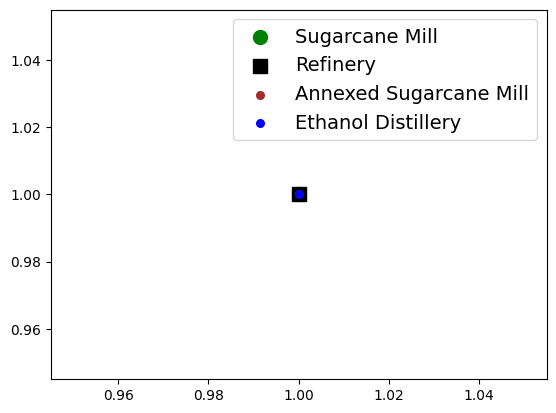

In [3]:
#Generate a legend for the figure above
plt.scatter(1,1,color='green',s=100, alpha = 1, marker = 'o', label = 'Sugarcane Mill')
plt.scatter(1,1,color='black',s=100, alpha = 1, marker = 's', label = 'Refinery')
plt.scatter(1,1, color='brown', s=30, alpha=1, marker = 'o', label = 'Annexed Sugarcane Mill')
plt.scatter(1,1, color='blue', s=30, alpha=1, marker = 'o', label = 'Ethanol Distillery')
plt.legend(fontsize = 14)
plt.savefig('Results_Figures/fourpanelinputdata_legend.png',bbox_inches='tight', dpi=500)
plt.show()

# Optimal Supply Chain Design Maps

In [4]:
#Pull all necessary data
this_file_path = os.getcwd()

#Latitude Longitude Data
mill_data = pd.read_excel('335MillsLatitudesLongitudes.xlsx') #mills
ref_data = pd.read_excel('OilRefineriesLatLong.xlsx') #refineries

#Pull mill & refinery data from different blend cases
#Mill Data
blend_mills1 = {}
blend_mills2 = {}
blend_mills3 = {}
blend_mills4 = {}
#Refinery Data
blend_ref1 = {} 
blend_ref2 = {} 
blend_ref3 = {}
blend_ref4 = {}
for i in [10,20,30,40,50]:
    #Refinery data
    blend_ref1[i] = pd.read_csv(this_file_path + '\\Case1\\interest_mid_blend_' + str(i) + '\key_results_ref.csv')
    blend_ref2[i] = pd.read_csv(this_file_path + '\\Case2\\interest_mid_blend_' + str(i) + '\key_results_ref.csv')
    blend_ref3[i] = pd.read_csv(this_file_path + '\\Case3\\interest_mid_blend_' + str(i) + '\key_results_ref.csv')
    blend_ref4[i] = pd.read_csv(this_file_path + '\\Case4\\interest_mid_blend_' + str(i) + '\key_results_ref.csv')
    #Mill data
    blend_mills1[i] = pd.read_csv(this_file_path + '\\Case1\\interest_mid_blend_' + str(i) + '\key_results_mills.csv')
    blend_mills2[i] = pd.read_csv(this_file_path + '\\Case2\\interest_mid_blend_' + str(i) + '\key_results_mills.csv')
    blend_mills3[i] = pd.read_csv(this_file_path + '\\Case3\\interest_mid_blend_' + str(i) + '\key_results_mills.csv')
    blend_mills4[i] = pd.read_csv(this_file_path + '\\Case4\\interest_mid_blend_' + str(i) + '\key_results_mills.csv')

In [5]:
#Sort locations of SAF producing mills, ethanol supplying mills, and blending/producing refineries for the 50% blend case

b = 50 #50% blend case change this parameter to expore other blend case solutions

#Sort locations SAF producing Mills
saf_mills1 = []
saf_mills3 = []

for i in range(len(blend_mills3[b]['mills'])):
    if blend_mills3[b]['SAF'][i] > 10:
        saf_mills3.append((blend_mills3[b]['mills'][i], mill_data['Longitude'][i], mill_data['Latitude'][i]))
        
for i in range(len(blend_mills1[b]['mills'])):
    if blend_mills1[b]['SAF'][i] > 10:
        saf_mills1.append((blend_mills1[b]['mills'][i], mill_data['Longitude'][i], mill_data['Latitude'][i]))



#Sort locations of ethanol supplying mills
eth_mills1 = []
eth_mills2 = []
eth_mills3 = []
eth_mills4 = []

for i in range(len(blend_mills3[b]['mills'])):
    if blend_mills3[b]['etref'][i] > 1:
        eth_mills3.append((blend_mills3[b]['mills'][i], mill_data['Longitude'][i], mill_data['Latitude'][i]))

for i in range(len(blend_mills1[b]['mills'])):
    if blend_mills1[b]['etref'][i] > 1:
        eth_mills1.append((blend_mills1[b]['mills'][i], mill_data['Longitude'][i], mill_data['Latitude'][i]))

for i in range(len(blend_mills2[b]['mills'])):
    if blend_mills2[b]['etr'][i] > 1:
        eth_mills2.append((blend_mills2[b]['mills'][i], mill_data['Longitude'][i], mill_data['Latitude'][i]))

for i in range(len(blend_mills4[b]['mills'])):
    if blend_mills4[b]['etr'][i] > 1:
        eth_mills4.append((blend_mills4[b]['mills'][i], mill_data['Longitude'][i], mill_data['Latitude'][i]))


#Sort locations of refineries (producing SAF or blending SAF)
refs1 = []
refs2 = []
refs3 = []
refs4 = []

for i in range(len(blend_ref3[b]['refinery'])):
    if blend_ref3[b]['blended SAF'][i] > 10:
        refs3.append((blend_ref3[b]['refinery'][i], ref_data['Longitude'][i], ref_data['Latitude'][i]))

for i in range(len(blend_ref1[b]['refinery'])):
    if blend_ref1[b]['blended SAF'][i] > 10:
        refs1.append((blend_ref1[b]['refinery'][i], ref_data['Longitude'][i], ref_data['Latitude'][i]))

for i in range(len(blend_ref2[b]['refinery'])):
    if blend_ref2[b]['blended SAF'][i] > 10:
        refs2.append((blend_ref2[b]['refinery'][i], ref_data['Longitude'][i], ref_data['Latitude'][i]))

for i in range(len(blend_ref4[b]['refinery'])):
        if blend_ref4[b]['blended SAF'][i] > 10:
            refs4.append((blend_ref4[b]['refinery'][i], ref_data['Longitude'][i], ref_data['Latitude'][i]))

#Create GeoDataframes for map figures
#Saf producing mills
safmillpoints1 = gpd.GeoDataFrame(
    saf_mills1,
    columns=["City", "Longitude", "Latitude"],
    geometry=[Point(xy[1], xy[2]) for xy in saf_mills1],
    crs="EPSG:4326"  # WGS84
)

safmillpoints3 = gpd.GeoDataFrame(
    saf_mills3,
    columns=["City", "Longitude", "Latitude"],
    geometry=[Point(xy[1], xy[2]) for xy in saf_mills3],
    crs="EPSG:4326"  # WGS84
)


#Ethanol supplying mills
ethmillpoints1 = gpd.GeoDataFrame(
    eth_mills1,
    columns=["City", "Longitude", "Latitude"],
    geometry=[Point(xy[1], xy[2]) for xy in eth_mills1],
    crs="EPSG:4326"  # WGS84
)

ethmillpoints3 = gpd.GeoDataFrame(
    eth_mills3,
    columns=["City", "Longitude", "Latitude"],
    geometry=[Point(xy[1], xy[2]) for xy in eth_mills3],
    crs="EPSG:4326"  # WGS84
)

ethmillpoints2 = gpd.GeoDataFrame(
    eth_mills2,
    columns=["City", "Longitude", "Latitude"],
    geometry=[Point(xy[1], xy[2]) for xy in eth_mills2],
    crs="EPSG:4326"  # WGS84
)

ethmillpoints4 = gpd.GeoDataFrame(
    eth_mills4,
    columns=["City", "Longitude", "Latitude"],
    geometry=[Point(xy[1], xy[2]) for xy in eth_mills4],
    crs="EPSG:4326"  # WGS84
)


#Refineries
refpoints1 = gpd.GeoDataFrame(
    refs1,
    columns=["City", "Longitude", "Latitude"],
    geometry=[Point(xy[1], xy[2]) for xy in refs1],
    crs="EPSG:4326"  # WGS84
)

refpoints3 = gpd.GeoDataFrame(
    refs3,
    columns=["City", "Longitude", "Latitude"],
    geometry=[Point(xy[1], xy[2]) for xy in refs3],
    crs="EPSG:4326"  # WGS84
)

refpoints2 = gpd.GeoDataFrame(
    refs2,
    columns=["City", "Longitude", "Latitude"],
    geometry=[Point(xy[1], xy[2]) for xy in refs2],
    crs="EPSG:4326"  # WGS84
)

refpoints4 = gpd.GeoDataFrame(
    refs4,
    columns=["City", "Longitude", "Latitude"],
    geometry=[Point(xy[1], xy[2]) for xy in refs4],
    crs="EPSG:4326"  # WGS84
)


In [6]:
#Display the total number of SAF producing mills, ethanol supplying mills, and blending/producing refineries for each case study

print('--------------------------------------------')
print('Blend Requirement: ', b, ' %')
print('--------------------------------------------')
print('Case 1')
print('SAF Producing Mills: ', len(saf_mills1))
print('Ethanol Supplying Mills: ', len(eth_mills1))
print('SAF Blending Refineries: ', len(refs1))
print('--------------------------------------------')
print('Case 2')
print('SAF Producing Mills: ', 0)
print('Ethanol Supplying Mills: ', len(eth_mills2))
print('SAF Producing & Blending Refineries: ', len(refs2))
print('--------------------------------------------')
print('Case 3')
print('SAF Producing Mills: ', len(saf_mills3))
print('Ethanol Supplying Mills: ', len(eth_mills3))
print('SAF Blending Refineries: ', len(refs3))
print('--------------------------------------------')
print('Case 4')
print('SAF Producing Mills: ', 0)
print('Ethanol Supplying Mills: ', len(eth_mills4))
print('SAF Producing & Blending Refineries: ', len(refs4))
print('--------------------------------------------')

--------------------------------------------
Blend Requirement:  50  %
--------------------------------------------
Case 1
SAF Producing Mills:  7
Ethanol Supplying Mills:  27
SAF Blending Refineries:  6
--------------------------------------------
Case 2
SAF Producing Mills:  0
Ethanol Supplying Mills:  40
SAF Producing & Blending Refineries:  7
--------------------------------------------
Case 3
SAF Producing Mills:  6
Ethanol Supplying Mills:  38
SAF Blending Refineries:  1
--------------------------------------------
Case 4
SAF Producing Mills:  0
Ethanol Supplying Mills:  55
SAF Producing & Blending Refineries:  6
--------------------------------------------


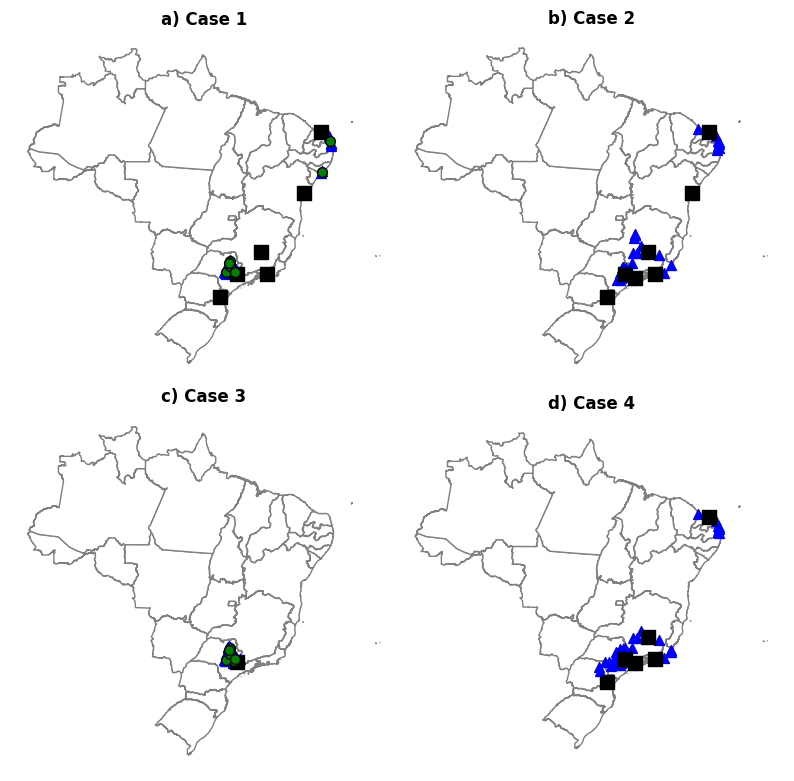

In [7]:
#Read the shape file containing political border data for Brazilian states
shapefile_path = 'ne_50m_admin_0_countries.shp'

fig, ax = plt.subplots(2,2,figsize=(10, 10)) 
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

#Case 1
brazil_states.plot(ax=ax[0,0], color='white', edgecolor='gray')
ethmillpoints1.plot(ax=ax[0,0], color='blue', markersize=50, alpha = 1, label = '1 - Ethanol Supplying Mill', marker = '^')
refpoints1.plot(ax=ax[0,0], color='black', markersize=100, alpha = 1, label = '1 - Refinery', marker = 's')
safmillpoints1.plot(ax=ax[0,0], color='green', markersize=50, alpha = 1, label = '1 - SAF Producing Mill', edgecolor='black')
ax[0,0].axis('off')
ax[0,0].set_title('a) Case 1', fontweight = 'bold')

#Case 3
brazil_states.plot(ax=ax[1,0], color='white', edgecolor='gray')
ethmillpoints3.plot(ax=ax[1,0], color='blue', markersize=50, alpha = 1, label = '3 - Ethanol Supplying Mill', marker = '^')
refpoints3.plot(ax=ax[1,0], color='black', markersize=100, alpha = 1, label = '3 - Refinery', marker = 's')
safmillpoints3.plot(ax=ax[1,0], color='green', markersize=50, alpha = 1, label = '3 - SAF Producing Mill', edgecolor='black')
ax[1,0].axis('off')
ax[1,0].set_title('c) Case 3', fontweight = 'bold')

#Case 2
brazil_states.plot(ax=ax[0,1], color='white', edgecolor='gray')
ethmillpoints2.plot(ax=ax[0,1], color='blue', markersize=50, alpha = 1, label = '1a - Ethanol Supplying Mill', marker = '^')
refpoints2.plot(ax=ax[0,1], color='black', markersize=100, alpha = 1, label = '1a - Refinery', marker = 's')
ax[0,1].axis('off')
ax[0,1].set_title('b) Case 2', fontweight = 'bold')

#Case 4
brazil_states.plot(ax=ax[1,1], color='white', edgecolor='gray')
ethmillpoints4.plot(ax=ax[1,1], color='blue', markersize=50, alpha = 1, label = '1b - Ethanol Supplying Mill', marker = '^')
refpoints4.plot(ax=ax[1,1], color='black', markersize=100, alpha = 1, label = '1b - Refinery', marker = 's')
ax[1,1].axis('off')
ax[1,1].set_title('d) Case 4', fontweight = 'bold')

plt.savefig('Results_Figures/optimaldesignmap' + str(b) + '.png',bbox_inches='tight', dpi=500)
plt.show()

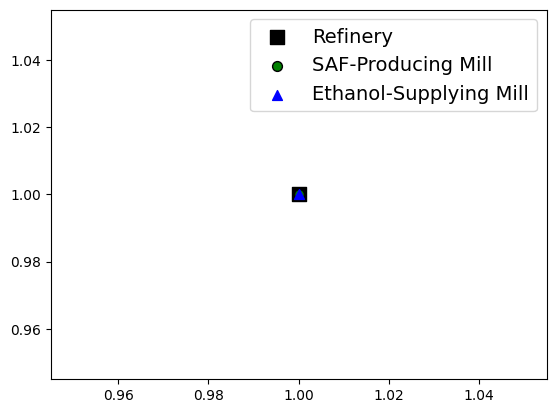

In [8]:
#Create a legend for the map figures to aviod spacing issues in the subplots
plt.scatter(1,1,color='black',s=100, alpha = 1, marker = 's', label = 'Refinery')
plt.scatter(1,1, color='green', s=50, alpha=1, marker = 'o', label = 'SAF-Producing Mill', edgecolor='black')
plt.scatter(1,1, color='blue', s=50, alpha=1, marker = '^', label = 'Ethanol-Supplying Mill')
plt.legend(fontsize = 14)
plt.savefig('Results_Figures/optimaldesign_legend.png',bbox_inches='tight', dpi=500)
plt.show()

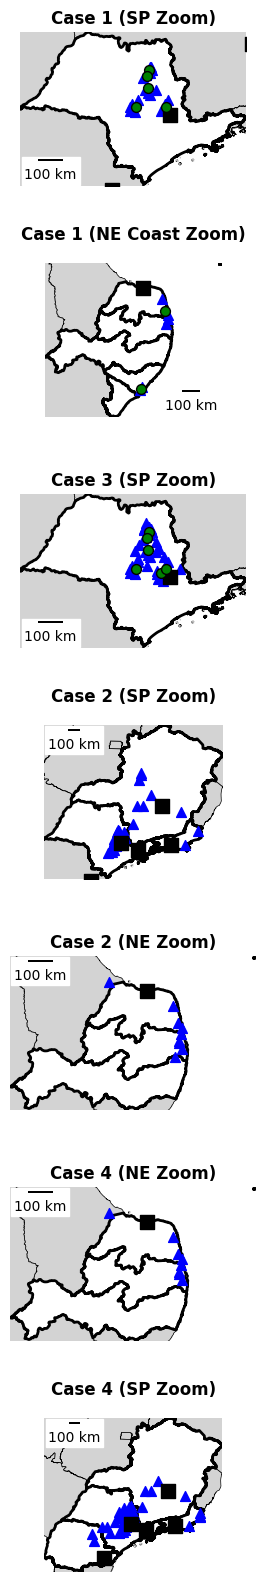

In [9]:
#Zoom in on concentrated areas for each case study, this cell takes ~1 min to run
from matplotlib_scalebar.scalebar import ScaleBar

if brazil_states.crs is None:
    brazil_states = brazil_states.set_crs(epsg=4326)

brazil_states = brazil_states.to_crs(epsg=5880)

#Transfor the data to use the metric system for scaling
ethmillpoints1 = ethmillpoints1.to_crs(brazil_states.crs)
ethmillpoints3 = ethmillpoints3.to_crs(brazil_states.crs)
ethmillpoints2 = ethmillpoints2.to_crs(brazil_states.crs)
ethmillpoints4 = ethmillpoints4.to_crs(brazil_states.crs)
refpoints1 = refpoints1.to_crs(brazil_states.crs)
refpoints3 = refpoints3.to_crs(brazil_states.crs)
refpoints2 = refpoints2.to_crs(brazil_states.crs)
refpoints4 = refpoints4.to_crs(brazil_states.crs)
safmillpoints1 = safmillpoints1.to_crs(brazil_states.crs)
safmillpoints3 = safmillpoints3.to_crs(brazil_states.crs)

#Name Sao paulo as a state to zoom on
sp = brazil_states[brazil_states['NAME_1'] == 'SÃ£o Paulo']

#Set bound to the states border
minx, miny, maxx, maxy = sp.total_bounds

fig, ax = plt.subplots(7,1,figsize=(4,20))
fig.subplots_adjust(hspace=0.5)

# Plot all states in light gray for context
brazil_states.plot(ax=ax[0], facecolor='lightgray', edgecolor='black', linewidth=0.5)

# Highlight São Paulo
sp.plot(ax=ax[0], facecolor='white', edgecolor='black', linewidth=2)

ethmillpoints1.plot(ax=ax[0], color='blue', markersize=50, alpha = 1, label = '1 - Ethanol Supplying Mill', marker = '^')
refpoints1.plot(ax=ax[0], color='black', markersize=100, alpha = 1, label = '1 - Refinery', marker = 's')
safmillpoints1.plot(ax=ax[0], color='green', markersize=50, alpha = 1, label = '1 - SAF Producing Mill', edgecolor='black')

scalebar = ScaleBar(
    dx=1,                # distance per unit in your CRS (meters if projected)
    units="m",           # your CRS is projected in meters
    dimension="si-length",
    fixed_value=100,
    fixed_units="km",  # 100 km in meters
    # label="100 km",
    location="lower left"
)
ax[0].add_artist(scalebar)

# Zoom to São Paulo bounds
ax[0].set_xlim(minx, maxx)
ax[0].set_ylim(miny, maxy)

ax[0].set_title("Case 1 (SP Zoom)", fontweight = 'bold')

ax[0].axis('off')

# List of states you want to zoom in on
states_to_plot = ['Rio Grande do Norte', 'ParaÃ­ba', 'Pernambuco', 'Alagoas', 'Sergipe']

# Filter GeoDataFrame
subset_states = brazil_states[brazil_states['NAME_1'].isin(states_to_plot)]

combined_geom = subset_states.unary_union
minx, miny, maxx, maxy = subset_states.total_bounds

# Plot all states in light gray for context
brazil_states.plot(ax=ax[1], facecolor='lightgray', edgecolor='black', linewidth=0.5)

# Highlight the three states
subset_states.plot(ax=ax[1], facecolor='white', edgecolor='black', linewidth=2)

ethmillpoints1.plot(ax=ax[1], color='blue', markersize=50, alpha = 1, label = '1 - Ethanol Supplying Mill', marker = '^')
refpoints1.plot(ax=ax[1], color='black', markersize=100, alpha = 1, label = '1 - Refinery', marker = 's')
safmillpoints1.plot(ax=ax[1], color='green', markersize=50, alpha = 1, label = '1 - SAF Producing Mill', edgecolor='black')

# Zoom to the bounds of the three states
ax[1].set_xlim(minx, maxx)
ax[1].set_ylim(miny, maxy)

scalebar = ScaleBar(
    dx=1,                # distance per unit in your CRS (meters if projected)
    units="m",           # your CRS is projected in meters
    dimension="si-length",
    fixed_value=100,
    fixed_units="km",  # 100 km in meters
    # label="100 km",
    location="lower right"
)
ax[1].add_artist(scalebar)

ax[1].axis('off')

ax[1].set_title("Case 1 (NE Coast Zoom)", fontweight = 'bold')

# Plot all states in light gray for context
brazil_states.plot(ax=ax[2], facecolor='lightgray', edgecolor='black', linewidth=0.5)

# Highlight São Paulo
sp.plot(ax=ax[2], facecolor='white', edgecolor='black', linewidth=2)
minx, miny, maxx, maxy = sp.total_bounds

# Plot points
ethmillpoints3.plot(ax=ax[2], color='blue', markersize=50, alpha = 1, label = '3 - Ethanol Supplying Mill', marker = '^')
refpoints3.plot(ax=ax[2], color='black', markersize=100, alpha = 1, label = '3 - Refinery', marker = 's')
safmillpoints3.plot(ax=ax[2], color='green', markersize=50, alpha = 1, label = '3 - SAF Producing Mill', edgecolor='black')

# Zoom to São Paulo bounds
ax[2].set_xlim(minx, maxx)
ax[2].set_ylim(miny, maxy)

ax[2].set_title("Case 3 (SP Zoom)", fontweight = 'bold')

ax[2].axis('off')

#Case 2 SP area
# List of states you want to zoom in on
states_to_plot = ['Rio de Janeiro', 'Minas Gerais', 'SÃ£o Paulo']

# Filter GeoDataFrame
subset_states = brazil_states[brazil_states['NAME_1'].isin(states_to_plot)]

combined_geom = subset_states.unary_union
minx, miny, maxx, maxy = subset_states.total_bounds

# Plot all states in light gray for context
brazil_states.plot(ax=ax[3], facecolor='lightgray', edgecolor='black', linewidth=0.5)

# Highlight the three states
subset_states.plot(ax=ax[3], facecolor='white', edgecolor='black', linewidth=2)

ethmillpoints2.plot(ax=ax[3], color='blue', markersize=50, alpha = 1, label = '2 - Ethanol Supplying Mill', marker = '^')
refpoints2.plot(ax=ax[3], color='black', markersize=100, alpha = 1, label = '2 - Refinery', marker = 's')

# Zoom to the bounds of the three states
ax[3].set_xlim(minx, maxx)
ax[3].set_ylim(miny, maxy)

scalebar = ScaleBar(
    dx=1,                # distance per unit in your CRS (meters if projected)
    units="m",           # your CRS is projected in meters
    dimension="si-length",
    fixed_value=100,
    fixed_units="km",  # 100 km in meters
    # label="100 km",
    location="lower left"
)
ax[2].add_artist(scalebar)

ax[3].axis('off')

ax[3].set_title("Case 2 (SP Zoom)", fontweight = 'bold')

scalebar = ScaleBar(
    dx=1,                # distance per unit in your CRS (meters if projected)
    units="m",           # your CRS is projected in meters
    dimension="si-length",
    fixed_value=100,
    fixed_units="km",  # 100 km in meters
    # label="100 km",
    location="upper left"
)
ax[3].add_artist(scalebar)

#Case 2 NE area
# List of states you want to zoom in on
states_to_plot = ['Rio Grande do Norte', 'ParaÃ­ba', 'Pernambuco']

# Filter GeoDataFrame
subset_states = brazil_states[brazil_states['NAME_1'].isin(states_to_plot)]

combined_geom = subset_states.unary_union
minx, miny, maxx, maxy = subset_states.total_bounds

# Plot all states in light gray for context
brazil_states.plot(ax=ax[4], facecolor='lightgray', edgecolor='black', linewidth=0.5)

# Highlight the three states
subset_states.plot(ax=ax[4], facecolor='white', edgecolor='black', linewidth=2)

ethmillpoints2.plot(ax=ax[4], color='blue', markersize=50, alpha = 1, label = '2 - Ethanol Supplying Mill', marker = '^')
refpoints2.plot(ax=ax[4], color='black', markersize=100, alpha = 1, label = '2 - Refinery', marker = 's')

# Zoom to the bounds of the three states
ax[4].set_xlim(minx, maxx)
ax[4].set_ylim(miny, maxy)

scalebar = ScaleBar(
    dx=1,                # distance per unit in your CRS (meters if projected)
    units="m",           # your CRS is projected in meters
    dimension="si-length",
    fixed_value=100,
    fixed_units="km",  # 100 km in meters
    # label="100 km",
    location="upper left"
)
ax[4].add_artist(scalebar)

ax[4].axis('off')

ax[4].set_title("Case 2 (NE Zoom)", fontweight = 'bold')

#Case 2 NE area
# List of states you want to zoom in on
states_to_plot = ['Rio Grande do Norte', 'ParaÃ­ba', 'Pernambuco']

# Filter GeoDataFrame
subset_states = brazil_states[brazil_states['NAME_1'].isin(states_to_plot)]

combined_geom = subset_states.unary_union
minx, miny, maxx, maxy = subset_states.total_bounds

# Plot all states in light gray for context
brazil_states.plot(ax=ax[5], facecolor='lightgray', edgecolor='black', linewidth=0.5)

# Highlight the three states
subset_states.plot(ax=ax[5], facecolor='white', edgecolor='black', linewidth=2)

ethmillpoints4.plot(ax=ax[5], color='blue', markersize=50, alpha = 1, label = '4 - Ethanol Supplying Mill', marker = '^')
refpoints4.plot(ax=ax[5], color='black', markersize=100, alpha = 1, label = '4 - Refinery', marker = 's')

# Zoom to the bounds of the three states
ax[5].set_xlim(minx, maxx)
ax[5].set_ylim(miny, maxy)

scalebar = ScaleBar(
    dx=1,                # distance per unit in your CRS (meters if projected)
    units="m",           # your CRS is projected in meters
    dimension="si-length",
    fixed_value=100,
    fixed_units="km",  # 100 km in meters
    # label="100 km",
    location="upper left"
)
ax[5].add_artist(scalebar)

ax[5].axis('off')

ax[5].set_title("Case 4 (NE Zoom)", fontweight = 'bold')

#Case 4 SP area
# List of states you want to zoom in on
states_to_plot = ['Rio de Janeiro', 'Minas Gerais', 'SÃ£o Paulo', 'ParanÃ¡']

# Filter GeoDataFrame
subset_states = brazil_states[brazil_states['NAME_1'].isin(states_to_plot)]

combined_geom = subset_states.unary_union
minx, miny, maxx, maxy = subset_states.total_bounds

# Plot all states in light gray for context
brazil_states.plot(ax=ax[6], facecolor='lightgray', edgecolor='black', linewidth=0.5)

# Highlight the three states
subset_states.plot(ax=ax[6], facecolor='white', edgecolor='black', linewidth=2)

ethmillpoints4.plot(ax=ax[6], color='blue', markersize=50, alpha = 1, label = '4 - Ethanol Supplying Mill', marker = '^')
refpoints4.plot(ax=ax[6], color='black', markersize=100, alpha = 1, label = '4 - Refinery', marker = 's')

# Zoom to the bounds of the three states
ax[6].set_xlim(minx, maxx)
ax[6].set_ylim(miny, maxy)

scalebar = ScaleBar(
    dx=1,                # distance per unit in your CRS (meters if projected)
    units="m",           # your CRS is projected in meters
    dimension="si-length",
    fixed_value=100,
    fixed_units="km",  # 100 km in meters
    # label="100 km",
    location="upper left"
)
ax[6].add_artist(scalebar)

ax[6].axis('off')

ax[6].set_title("Case 4 (SP Zoom)", fontweight = 'bold')

plt.savefig('Results_Figures/optimalsclocationszoom.png',bbox_inches='tight', dpi=500)
plt.show()
